In [ ]:
!unzip -u "/content/drive/MyDrive/data_x_ray.zip" -d "/content/drive/MyDrive"

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/data_x_ray/COVID/COVID-223.png  
  inflating: /content/drive/MyDrive/data_x_ray/COVID/COVID-224.png  
  inflating: /content/drive/MyDrive/data_x_ray/COVID/COVID-225.png  
  inflating: /content/drive/MyDrive/data_x_ray/COVID/COVID-226.png  
  inflating: /content/drive/MyDrive/data_x_ray/COVID/COVID-227.png  
  inflating: /content/drive/MyDrive/data_x_ray/COVID/COVID-228.png  
  inflating: /content/drive/MyDrive/data_x_ray/COVID/COVID-229.png  
  inflating: /content/drive/MyDrive/data_x_ray/COVID/COVID-23.png  
  inflating: /content/drive/MyDrive/data_x_ray/COVID/COVID-230.png  
  inflating: /content/drive/MyDrive/data_x_ray/COVID/COVID-231.png  
  inflating: /content/drive/MyDrive/data_x_ray/COVID/COVID-232.png  
  inflating: /content/drive/MyDrive/data_x_ray/COVID/COVID-233.png  
  inflating: /content/drive/MyDrive/data_x_ray/COVID/COVID-234.png  
  inflating: /content/drive/MyDrive/data_x_ray/COVID/

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

In [ ]:
data_dir = '/content/drive/MyDrive/data_x_ray'
def load_split_train_test(datadir, valid_size = .2):
    train_transforms = transforms.Compose([transforms.Resize(224),
                                       transforms.ToTensor(),
                                       ])
    test_transforms = transforms.Compose([transforms.Resize(224),
                                      transforms.ToTensor(),
                                      ])
    train_data = datasets.ImageFolder(datadir,       
                    transform=train_transforms)
    test_data = datasets.ImageFolder(datadir,
                    transform=test_transforms)
    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    np.random.shuffle(indices)
    from torch.utils.data.sampler import SubsetRandomSampler
    train_idx, test_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)
    trainloader = torch.utils.data.DataLoader(train_data,
                   sampler=train_sampler, batch_size=64)
    testloader = torch.utils.data.DataLoader(test_data,
                   sampler=test_sampler, batch_size=64)
    return trainloader, testloader
trainloader, testloader = load_split_train_test(data_dir, .2)
print(trainloader.dataset.classes)

['COVID', 'Normal']


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() 
                                  else "cpu")
model = models.resnet50(pretrained=True)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
for param in model.parameters():
    param.requires_grad = False
    
model.fc = nn.Sequential(nn.Linear(2048, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, 10),
                                 nn.LogSoftmax(dim=1))
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
epochs = 4
steps = 0
running_loss = 0
print_every = 5
train_losses, test_losses = [], []
for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device),labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    test_loss += batch_loss.item()
                    
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy +=torch.mean(equals.type(torch.FloatTensor)).item()
            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(testloader))                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
            model.train()
torch.save(model, '/content/drive/MyDrive/dataset/covid_model.pth')

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch 1/4.. Train loss: 2.139.. Test loss: 1.370.. Test accuracy: 0.512
Epoch 1/4.. Train loss: 0.960.. Test loss: 0.632.. Test accuracy: 0.656
Epoch 1/4.. Train loss: 0.455.. Test loss: 0.146.. Test accuracy: 0.944
Epoch 1/4.. Train loss: 0.339.. Test loss: 2.195.. Test accuracy: 0.476
Epoch 1/4.. Train loss: 0.304.. Test loss: 0.097.. Test accuracy: 0.969
Epoch 1/4.. Train loss: 0.327.. Test loss: 0.292.. Test accuracy: 0.901
Epoch 1/4.. Train loss: 0.167.. Test loss: 0.439.. Test accuracy: 0.849
Epoch 2/4.. Train loss: 0.127.. Test loss: 0.160.. Test accuracy: 0.944
Epoch 2/4.. Train loss: 0.120.. Test loss: 0.164.. Test accuracy: 0.945
Epoch 2/4.. Train loss: 0.150.. Test loss: 0.149.. Test accuracy: 0.948
Epoch 2/4.. Train loss: 0.124.. Test loss: 0.096.. Test accuracy: 0.966
Epoch 2/4.. Train loss: 0.177.. Test loss: 0.133.. Test accuracy: 0.956
Epoch 2/4.. Train loss: 0.135.. Test loss: 0.138.. Test accuracy: 0.954
Epoch 2/4.. Train loss: 0.102.. Test loss: 0.243.. Test accuracy

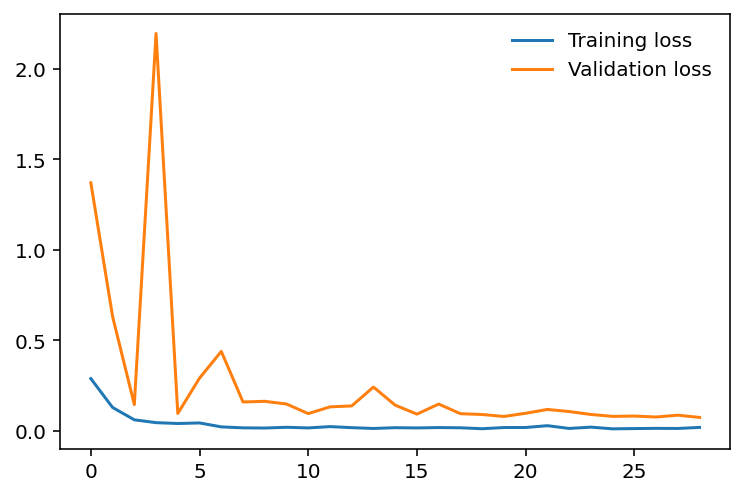

In [ ]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

In [ ]:
# track test loss
test_loss     = 0.0
class_correct = [0]*2
class_total   = [0]*2

model.eval()

# For generating confusion matrix
conf_matrix = np.zeros((2,2))

# iterate over test data
for data, target in testloader:
    # move tensors to GPU if CUDA is available
    data   = data.to(device)
    target = target.to(device)
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if device == "cpu" else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(target.size(0)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
        
        # Update confusion matrix
        conf_matrix[label][pred.data[i]] += 1

# average test loss
test_loss = test_loss/len(testloader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(2):
    if class_total[i] > 0:
        print('Test Accuracy of %3s: %2d%% (%2d/%2d)' % (
            i, 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %3s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))
print(conf_matrix)

Test Loss: 0.016129

Test Accuracy of   0: 98% (281/286)
Test Accuracy of   1: 95% (289/302)

Test Accuracy (Overall): 96% (570/588)
[[281.   5.]
 [ 13. 289.]]


In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[281.   5.]
 [ 13. 289.]]


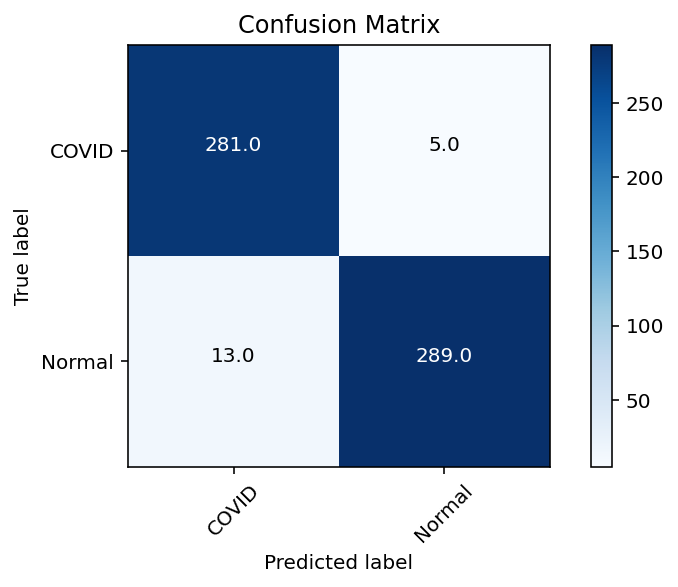

In [ ]:
import itertools  
cm_plot_labels = ['COVID','Normal']
plot_confusion_matrix(cm=conf_matrix, classes=cm_plot_labels, title='Confusion Matrix')
from sklearn.metrics import accuracy_score
